In [1]:
import numpy as np
import matplotlib.pyplot as plt

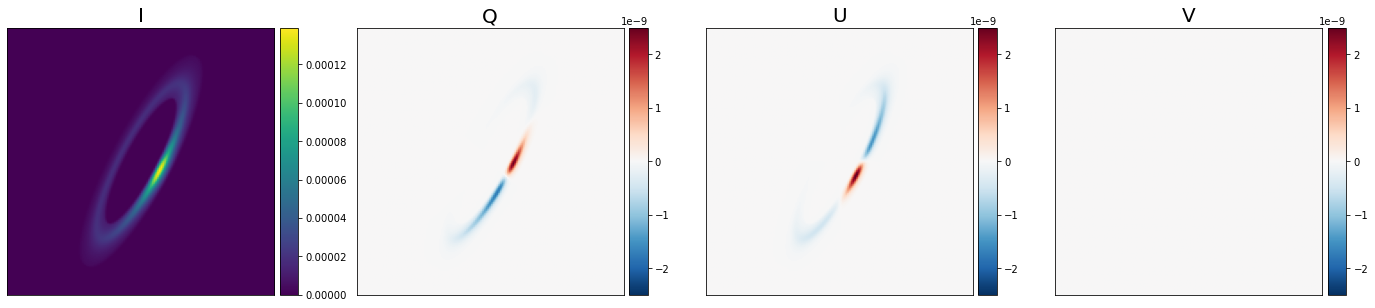

In [14]:
from astropy.io import fits

pth = 'HR4796A/'
I = fits.getdata(pth+'I_HR4796A.fits')
Q = fits.getdata(pth+'Q_HR4796A.fits')
U = fits.getdata(pth+'U_HR4796A.fits')
V = fits.getdata(pth+'V_HR4796A.fits')

# crop out the middle
center = int(I.shape[0] / 2)
cut = int(150/2)

I = I[center-cut:center+cut,center-cut:center+cut]
Q = Q[center-cut:center+cut,center-cut:center+cut]
U = U[center-cut:center+cut,center-cut:center+cut]
V = V[center-cut:center+cut,center-cut:center+cut]


S = np.moveaxis(np.array([I,Q,U,V]),0,-1)[..., np.newaxis]

plot_stokes(I, Q, U, V, power_scale=1/2, vmin=-2.5e-9, vmax=2.5e-9)

In [3]:
def broadcast_kron(a,b):
    """broadcasted kronecker product of two N,M,...,2,2 arrays. Used for jones -> mueller conversion
    In the unbroadcasted case, this output looks like

    out = [a[0,0]*b,a[0,1]*b]
          [a[1,0]*b,a[1,1]*b]

    where out is a N,M,...,4,4 array. I wrote this to work for generally shaped kronecker products where the matrix
    is contained in the last two axes, but it's only tested for the Nx2x2 case

    Parameters
    ----------
    a : numpy.ndarray
        N,M,...,2,2 array used to scale b in kronecker product
    b : numpy.ndarray
        N,M,...,2,2 array used to form block matrices in kronecker product

    Returns
    -------
    out
        N,M,...,4,4 array
    """

    return np.einsum('...ik,...jl',a,b).reshape([*a.shape[:-2],int(a.shape[-2]*b.shape[-2]),int(a.shape[-1]*b.shape[-1])])

def jones_to_mueller(jones):
    """Construct a Mueller Matrix given a Jones Matrix. From Chipman, Lam, and Young Eq (6.99).

    Parameters
    ----------
    jones : ndarray with final dimensions 2x2
        The complex-valued jones matrices to convert into mueller matrices

    Returns
    -------
    M : np.ndarray
        Mueller matrix
    """

    U = np.array([[1,0,0,1],
                  [1,0,0,-1],
                  [0,1,1,0],
                  [0,1j,-1j,0]])/np.sqrt(2)
    
    if jones.ndim == 2:
        jprod = np.kron(np.conj(jones),jones)
    else:
        # broadcasted kronecker product with einsum
        jprod = broadcast_kron(np.conj(jones),jones)
    M = np.real(U @ jprod @ np.linalg.inv(U))

    return M

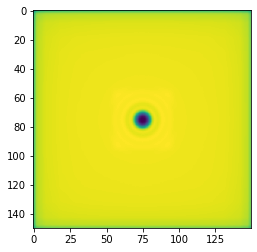

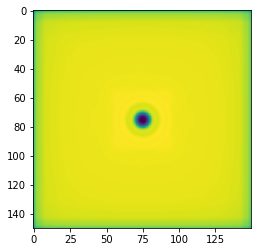

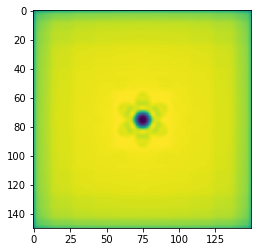

In [4]:
# set up cases
stokes_postcov_gsmts = []
telescopes = ['TMT','ELT','GMT']

for gsmt in telescopes:

    # Load up the PSF data outer
    psf_grid_real = np.load('psf_grids/'+gsmt+'_grid_15LD_61tilts_128focal_order4_20pct_2indx_real.npy')
    psf_grid_imag = np.load('psf_grids/'+gsmt+'_grid_15LD_61tilts_128focal_order4_20pct_2indx_imag.npy')
    psf_grid = psf_grid_real + 1j*psf_grid_imag

    # Load up the PSF data inner
    psf_inner_real = np.load('psf_grids/'+gsmt+'_grid_4LD_17tilts_128focal_order4_20pct_2indx_real.npy')
    psf_inner_imag = np.load('psf_grids/'+gsmt+'_grid_4LD_17tilts_128focal_order4_20pct_2indx_imag.npy')
    psf_inner = psf_inner_real + 1j*psf_inner_imag

    # just stuff it
    center = int(psf_grid.shape[0]/2)
    psf_grid[center-8:center+9,center-8:center+9] = psf_inner

    psfsum = np.sum(np.abs(psf_grid)**2, axis=0)
    psfsum = np.sum(psfsum, axis=0)

    plt.figure()
    plt.imshow(psfsum[0,0])
    plt.show()

    # shift the axes over
    psf_jones_matrix = np.moveaxis(np.moveaxis(psf_grid, 2, -1), 2, -1)
    psf_jones_matrix.shape

    psf_mueller_matrix = np.zeros([*psf_jones_matrix.shape[:-2], 4, 4])

    for i in range(psf_jones_matrix.shape[0]):
        for j in range(psf_jones_matrix.shape[1]):

            psf_mueller_matrix[i,j] = jones_to_mueller(psf_jones_matrix[i,j])

    S_out = np.zeros_like(S)

    for i in range(psf_mueller_matrix.shape[0]):
        for j in range(psf_mueller_matrix.shape[1]):

            M = psf_mueller_matrix[i, j]
            S_out += M @ S

    stokes_postcov_gsmts.append(S_out)

<ipython-input-15-9c5c9fc9a3cb>:3: RuntimeWarning: invalid value encountered in divide
  q_orig = S[...,1,0] / S[...,0,0]
<ipython-input-15-9c5c9fc9a3cb>:4: RuntimeWarning: invalid value encountered in divide
  u_orig = S[...,2,0] / S[...,0,0]
<ipython-input-15-9c5c9fc9a3cb>:13: RuntimeWarning: invalid value encountered in divide
  plt.imshow(stokes[...,1,0] / stokes[...,0,0] - q_orig, cmap='RdBu_r', vmin=-0.05, vmax=0.05)
<ipython-input-15-9c5c9fc9a3cb>:20: RuntimeWarning: invalid value encountered in divide
  plt.imshow(stokes[...,2,0] / stokes[...,0,0] - u_orig, cmap='RdBu_r', vmin=-0.04, vmax=0.04)
<ipython-input-15-9c5c9fc9a3cb>:27: RuntimeWarning: invalid value encountered in divide
  plt.imshow(stokes[...,3,0] / stokes[...,0,0], cmap='RdBu_r', vmin=-0.3, vmax=0.3)


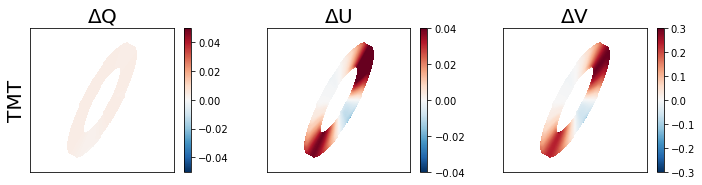

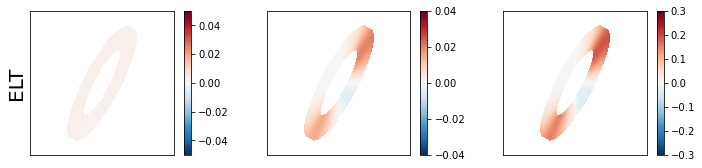

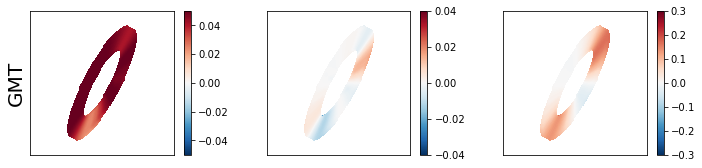

In [15]:
offset = [1,4,7]

q_orig = S[...,1,0] / S[...,0,0]
u_orig = S[...,2,0] / S[...,0,0]

for i, (gsmt, stokes, off) in enumerate(zip(telescopes, stokes_postcov_gsmts, offset)):

    plt.figure(figsize=[12,9])
    plt.subplot(3,3,off)
    if i == 0:
        plt.title(r'$\Delta$'+'Q',fontsize=20)
    plt.ylabel(gsmt, fontsize=20)
    plt.imshow(stokes[...,1,0] / stokes[...,0,0] - q_orig, cmap='RdBu_r', vmin=-0.05, vmax=0.05)
    plt.xticks([],[])
    plt.yticks([],[])
    plt.colorbar()
    plt.subplot(3,3,off+1)
    if i == 0:
        plt.title(r'$\Delta$'+'U',fontsize=20)
    plt.imshow(stokes[...,2,0] / stokes[...,0,0] - u_orig, cmap='RdBu_r', vmin=-0.04, vmax=0.04)
    plt.xticks([],[])
    plt.yticks([],[])
    plt.colorbar()
    plt.subplot(3,3,off+2)
    if i == 0:
        plt.title(r'$\Delta$'+'V',fontsize=20)
    plt.imshow(stokes[...,3,0] / stokes[...,0,0], cmap='RdBu_r', vmin=-0.3, vmax=0.3)
    plt.xticks([],[])
    plt.yticks([],[])
    plt.colorbar()

plt.show()


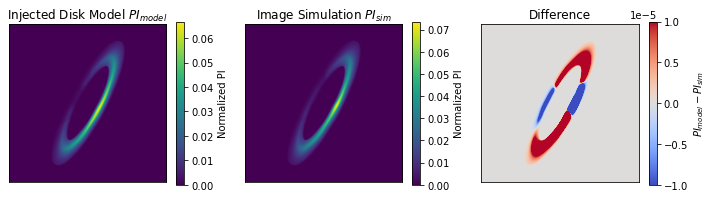

In [7]:
# Compare in polarized intensity
PI_original = np.sqrt(S[...,1,0]**2 + S[...,2,0]**2)
PI_original /= np.sum(PI_original)
PI_postconv = np.sqrt(S_out[...,1,0]**2 + S_out[...,2,0]**2)
PI_postconv /= np.sum(PI_postconv)

power = 1/2

from matplotlib.colors import SymLogNorm

plt.figure(figsize=[12,3])
plt.subplot(131)
plt.title('Injected Disk Model ' + r'$PI_{model}$')
plt.imshow(PI_original**power)
plt.colorbar(label='Normalized PI')
plt.xticks([],[])
plt.yticks([],[])
plt.subplot(132)
plt.title('Image Simulation ' + r'$PI_{sim}$')
plt.imshow(PI_postconv**power)
plt.colorbar(label='Normalized PI')
plt.xticks([],[])
plt.yticks([],[])
plt.subplot(133)
level = 1e-5
plt.title('Difference')
plt.imshow((PI_original - PI_postconv),cmap='coolwarm',vmin=-level,vmax=level)
plt.colorbar(label=r'$PI_{model} - PI_{sim}$')

plt.xticks([],[])
plt.yticks([],[])
plt.show()

<ipython-input-12-fc09da4d08ff>:32: RuntimeWarning: invalid value encountered in divide
  S_after_norm = [s/S_out[...,0,0] for s in S_list]
<ipython-input-12-fc09da4d08ff>:34: RuntimeWarning: invalid value encountered in divide
  S_orig_norm = [s/S_orig[0] for s in S_orig]


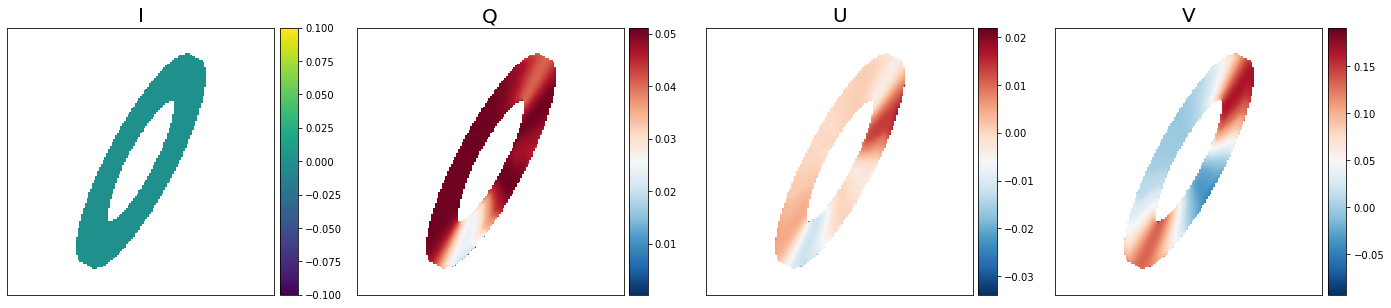

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

def plot_stokes(I, Q, U, V, power_scale=1/3, vmin=None, vmax=None):

    data = [I, Q, U, V]
    titles = ['I','Q','U','V']

    fig, axs = plt.subplots(figsize=[24,6], ncols=4)

    for i, (ax, im, tit) in enumerate(zip(axs, data, titles)):

        if i == 0:
            im = ax.imshow(im**power_scale)
        else:
            im = ax.imshow(im, cmap='RdBu_r', vmin=vmin, vmax=vmax)

        div = make_axes_locatable(ax)
        cax = div.append_axes("right", size="7%", pad="2%")
        fig.colorbar(im, cax=cax)
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])
        ax.set_title(tit, fontsize=20)

    plt.show()



S_list = [S_out[...,0,0],S_out[...,1,0],S_out[...,2,0],S_out[...,3,0]]
S_after_norm = [s/S_out[...,0,0] for s in S_list]
S_orig = [I,Q,U,V]
S_orig_norm = [s/S_orig[0] for s in S_orig]
S_diff = [s - o for s,o in zip(S_after_norm, S_orig_norm)]
# S_diff[-1] = S_after_norm[-1]

plot_stokes(*S_diff, power_scale=1)

In [14]:
np.save('normalized_disk_stokes_HR4796A/elt_order4.npy',S_after_norm)

In [15]:
S.shape

(150, 150, 4, 1)